# Simple Moving Average (SMA) Optimizer

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute
plt.style.use("seaborn")
#!pip install pandas_datareader
import pandas_datareader.data as web

### Data Scraping

In [14]:
start= pd.to_datetime('2016-01-01')
end= pd.to_datetime('2021-03-01')

btc = web.DataReader('BTC-USD','yahoo',start, end)
eth = web.DataReader('ETH-USD','yahoo',start, end)
ltc = web.DataReader('LTC-USD','yahoo',start, end)
dash = web.DataReader('DASH-USD','yahoo',start, end)

In [15]:
btc.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-01,436.246002,427.515015,430.721008,434.334015,36278900.0,434.334015
2016-01-02,436.062012,431.869995,434.622009,433.437988,30096600.0,433.437988
2016-01-03,433.743011,424.705994,433.578003,430.010986,39633800.0,430.010986
2016-01-04,434.516998,429.084015,430.061005,433.091003,38477500.0,433.091003
2016-01-05,434.182007,429.675995,433.069000,431.959991,34522600.0,431.959991


In [16]:
#eliminando outras colunas para ficar apenas Close
btc.drop(['High','Low','Open','Volume','Adj Close'], axis=1,inplace=True)
eth.drop(['High','Low','Open','Volume','Adj Close'], axis=1,inplace=True)
ltc.drop(['High','Low','Open','Volume','Adj Close'], axis=1,inplace=True)
dash.drop(['High','Low','Open','Volume','Adj Close'], axis=1,inplace=True)
#concatenar para os ativos para 'Close'
df = pd.concat([btc,eth,ltc,dash],axis=1) 
#mudar os headers da colunas
df.columns = ['BTC','ETH','LTC','DASH']

In [19]:
#salvar um um arquivo CSV
df.to_csv("cryptos.csv")

In [20]:
df.BTC.head()

Date
2016-01-01    434.334015
2016-01-02    433.437988
2016-01-03    430.010986
2016-01-04    433.091003
2016-01-05    431.959991
Name: BTC, dtype: float64

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1884 entries, 2016-01-01 to 2021-03-02
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BTC     1884 non-null   float64
 1   ETH     1884 non-null   float64
 2   LTC     1884 non-null   float64
 3   DASH    1884 non-null   float64
dtypes: float64(4)
memory usage: 73.6 KB


### Hands-on

In [86]:
class SMABacktester(): # with ptc 
    ''' Class for the vectorized backtesting of SMA-based trading strategies.

    Attributes
    ==========
    symbol: str
        ticker symbol with which to work with
    SMA_S: int
        time window in days for shorter SMA
    SMA_L: int
        time window in days for longer SMA
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
    tc: float
        proportional transaction costs per trade
        
        
    Methods
    =======
    get_data:
        retrieves and prepares the data
        
    set_parameters:
        sets one or two new SMA parameters
        
    test_strategy:
        runs the backtest for the SMA-based strategy
        
    plot_results:
        plots the performance of the strategy compared to buy and hold
        
    update_and_run:
        updates SMA parameters and returns the negative absolute performance (for minimization algorithm)
        
    optimize_parameters:
        implements a brute force optimization for the two SMA parameters
    '''
    
    def __init__(self, symbol, SMA_S, SMA_L, start, end, tc):
        self.symbol = symbol
        self.SMA_S = SMA_S
        self.SMA_L = SMA_L
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None 
        self.get_data()
        
    def __repr__(self):
        return "SMABacktester(symbol = {}, SMA_S = {}, SMA_L = {}, start = {}, end = {})".format(self.symbol, self.SMA_S, self.SMA_L, self.start, self.end)
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv("cryptos.csv", parse_dates = ["Date"], index_col = "Date")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        raw["SMA_S"] = raw["price"].rolling(self.SMA_S).mean()
        raw["SMA_L"] = raw["price"].rolling(self.SMA_L).mean()
        self.data = raw
        
    def set_parameters(self, SMA_S = None, SMA_L = None):
        ''' Updates SMA parameters and resp. time series.
        '''
        if SMA_S is not None:
            self.SMA_S = SMA_S
            self.data["SMA_S"] = self.data["price"].rolling(self.SMA_S).mean()
        if SMA_L is not None:
            self.SMA_L = SMA_L
            self.data["SMA_L"] = self.data["price"].rolling(self.SMA_L).mean()
            
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data["SMA_S"] > data["SMA_L"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine when a trade takes place
        data["trades"] = data.position.diff().fillna(0).abs()
        trades=data.trades.value_counts()
        
        # subtract transaction costs from return when trade takes place
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        perf = data["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
        return round(perf, 6), round(outperf, 6), trades
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = "{} | SMA_S = {} | SMA_L = {} | TC = {}".format(self.symbol, self.SMA_S, self.SMA_L, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
        
    def update_and_run(self, SMA):
        ''' Updates SMA parameters and returns the negative absolute performance (for minimization algorithm).

        Parameters
        ==========
        SMA: tuple
            SMA parameter tuple
        '''
        self.set_parameters(int(SMA[0]), int(SMA[1]))
        return -self.test_strategy()[0]
    
    def optimize_parameters(self, SMA1_range, SMA2_range):
        ''' Finds global maximum given the SMA parameter ranges.

        Parameters
        ==========
        SMA1_range, SMA2_range: tuple
            tuples of the form (start, end, step size)
        '''
        opt = brute(self.update_and_run, (SMA1_range, SMA2_range), finish=None)
        return opt, -self.update_and_run(opt)

In [87]:
tester_S = SMABacktester("BTC", 50, 200, "2016-01-01", "2021-03-01", 0)

In [88]:
#checando se a fução está ok com dados de inputs
tester_S

SMABacktester(symbol = BTC, SMA_S = 50, SMA_L = 200, start = 2016-01-01, end = 2021-03-01)

In [89]:
#retorno, diferença em relação a buy and hold, número de trade posição (2,2) da matriz
tester_S.test_strategy()

(58.42796,
 -15.306698,
 0.0    1677
 2.0       6
 Name: trades, dtype: int64)

In [90]:
tester_S.results

,price,returns,SMA_S,SMA_L,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,
2016-07-18,672.864014,-0.000360,649.387040,481.153594,1,-0.000360,0.0,0.999640,0.999640
2016-07-19,665.684998,-0.010727,652.073020,482.314829,1,-0.010727,0.0,0.988975,0.988975
2016-07-20,665.012024,-0.001011,654.634861,483.489834,1,-0.001011,0.0,0.987975,0.987975
2016-07-21,650.619019,-0.021881,656.887802,484.577474,1,-0.021881,0.0,0.966592,0.966592
2016-07-22,655.556030,0.007560,658.615043,485.695454,1,0.007560,0.0,0.973927,0.973927
...,...,...,...,...,...,...,...,...,...
2021-02-25,47093.851562,-0.053970,40752.937852,21811.733013,1,-0.053970,0.0,69.964984,55.440838
2021-02-26,46339.761719,-0.016142,40892.312227,21985.424458,1,-0.016142,0.0,68.844670,54.553092
2021-02-27,46188.453125,-0.003271,41000.129102,22157.596494,1,-0.003271,0.0,68.619878,54.374966


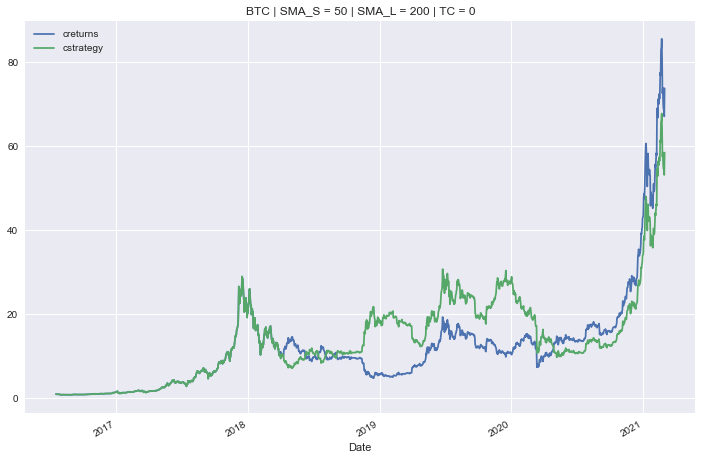

In [91]:
tester_S.plot_results()

In [94]:
#otimizar as médias móveis para o ativo
#apresenta o resultado média curta, média longa, retorno em relação buy and hold
tester_S.optimize_parameters((9, 50, 1), (100, 300, 1))

(array([ 42., 110.]), 365.900628)

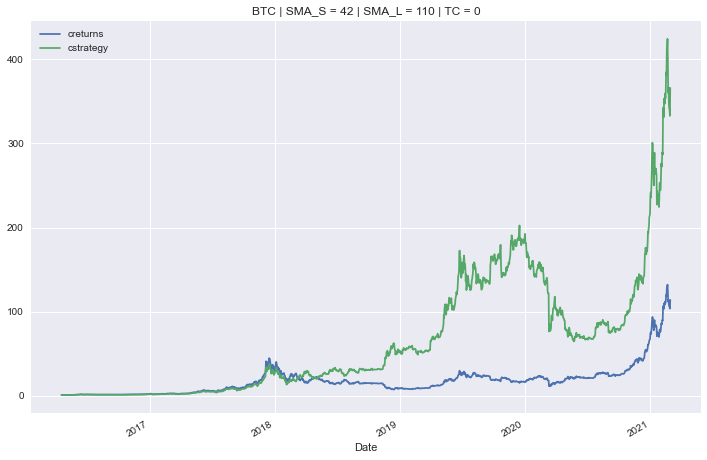

In [95]:
tester_S.plot_results()

### Backtesting & Forward Testing

In [96]:
#definir o intervalo de treinamento. Geralmente um pedaço do dataset, 70% em média
train_S = SMABacktester("BTC", 50, 200, "2016-01-01", "2019-10-01", 0)

In [97]:
train_S.optimize_parameters((9, 50, 1), (100, 300, 1)) # optimizing strategy & backtesting ("in-sample")

(array([ 38., 100.]), 160.736828)

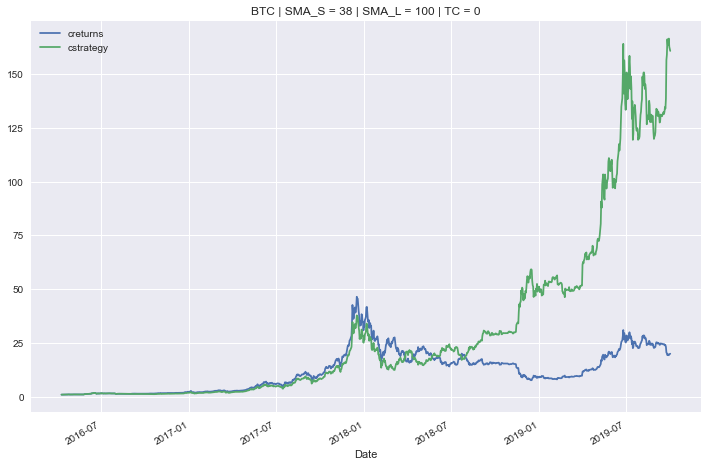

In [98]:
train_S.plot_results()

In [99]:
#agora replicando na outra metade

#AQUI.......... #sma curta e longa tomados dos melhores resultados do treinamento (acima)

#start, end a parte final do dataset

tester_O1 = SMABacktester("BTC", 38, 100, "2019-10-01", "2021-03-01", 0)

In [100]:
tester_O1.test_strategy() # forward testing ("out-sample")

(1.833142,
 -4.465982,
 0.0    408
 2.0      5
 Name: trades, dtype: int64)

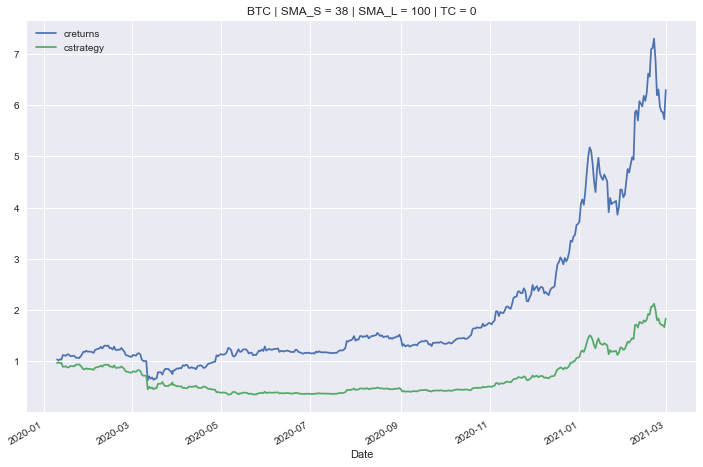

In [101]:
tester_O1.plot_results()
#o resultado da estratégia foi melhor ou pior?

In [102]:
tester_O1.optimize_parameters((9, 50, 1), (100, 300, 1)) # optimizing strategy & backtesting ("in-sample")

(array([ 28., 218.]), 6.67523)

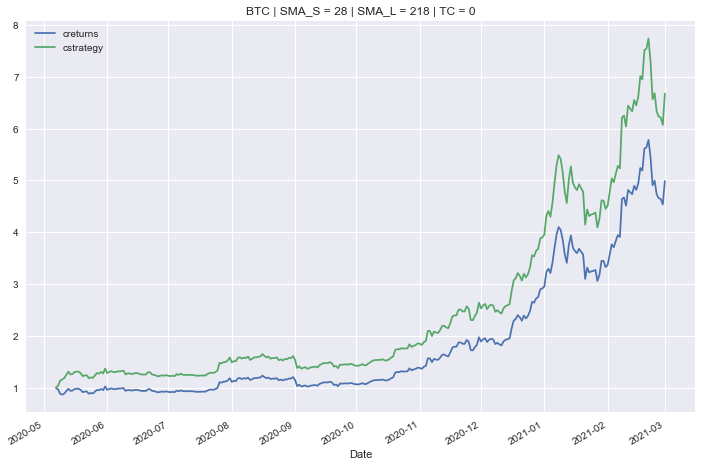

In [103]:
tester_O1.plot_results()

In [ ]:
#life is not easy

# Exponential Moving Average (EMA) Optimizer

In [74]:
class EMABacktester(): 
    ''' Class for the vectorized backtesting of EMA-based trading strategies.

    Attributes
    ==========
    symbol: str
        ticker symbol with which to work with
    EMA_S: int
        time window in days for shorter EMA
    EMA_L: int
        time window in days for longer EMA
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
    tc: float
        proportional transaction costs per trade
        
        
    Methods
    =======
    get_data:
        retrieves and prepares the data
        
    set_parameters:
        sets one or two new EMA parameters
        
    test_strategy:
        runs the backtest for the EMA-based strategy
        
    plot_results:
        plots the performance of the strategy compared to buy and hold
        
    update_and_run:
        updates EMA parameters and returns the negative absolute performance (for minimization algorithm)
        
    optimize_parameters:
        implements a brute force optimization for the two EMA parameters
    '''
    
    def __init__(self, symbol, EMA_S, EMA_L, start, end, tc):
        self.symbol = symbol
        self.EMA_S = EMA_S
        self.EMA_L = EMA_L
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None 
        self.get_data()
        
    def __repr__(self):
        return "EMABacktester(symbol = {}, EMA_S = {}, EMA_L = {}, start = {}, end = {})".format(self.symbol, self.EMA_S, self.EMA_L, self.start, self.end)
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv("cryptos.csv", parse_dates = ["Date"], index_col = "Date")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        raw["EMA_S"] = raw["price"].ewm(span = self.EMA_S, min_periods = self.EMA_S).mean() 
        raw["EMA_L"] = raw["price"].ewm(span = self.EMA_L, min_periods = self.EMA_L).mean() 
        self.data = raw
        
    def set_parameters(self, EMA_S = None, EMA_L = None):
        ''' Updates EMA parameters and resp. time series.
        '''
        if EMA_S is not None:
            self.EMA_S = EMA_S
            self.data["EMA_S"] = self.data["price"].ewm(span = self.EMA_S, min_periods = self.EMA_S).mean() 
        if EMA_L is not None:
            self.EMA_L = EMA_L
            self.data["EMA_L"] = self.data["price"].ewm(span = self.EMA_L, min_periods = self.EMA_L).mean()
            
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data["EMA_S"] > data["EMA_L"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine when a trade takes place
        data["trades"] = data.position.diff().fillna(0).abs()
        trades=data.trades.value_counts()
        
        # subtract transaction costs from return when trade takes place
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        perf = data["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
        return round(perf, 6), round(outperf, 6), trades
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = "{} | EMA_S = {} | EMA_L = {} | TC = {}".format(self.symbol, self.EMA_S, self.EMA_L, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
        
    def update_and_run(self, EMA):
        ''' Updates EMA parameters and returns the negative absolute performance (for minimization algorithm).

        Parameters
        ==========
        EMA: tuple
            EMA parameter tuple
        '''
        self.set_parameters(int(EMA[0]), int(EMA[1]))
        return -self.test_strategy()[0]
    
    def optimize_parameters(self, EMA1_range, EMA2_range):
        ''' Finds global maximum given the EMA parameter ranges.

        Parameters
        ==========
        EMA1_range, EMA2_range: tuple
            tuples of the form (start, end, step size)
        '''
        opt = brute(self.update_and_run, (EMA1_range, EMA2_range), finish=None)
        return opt, -self.update_and_run(opt)

In [78]:
tester_E = EMABacktester("BTC", 50, 200, "2016-01-01", "2021-03-01", 0)
tester_E

EMABacktester(symbol = BTC, EMA_S = 50, EMA_L = 200, start = 2016-01-01, end = 2021-03-01)

In [79]:
tester_E.test_strategy()

(20.144935,
 -53.589723,
 0.0    1675
 2.0       8
 Name: trades, dtype: int64)

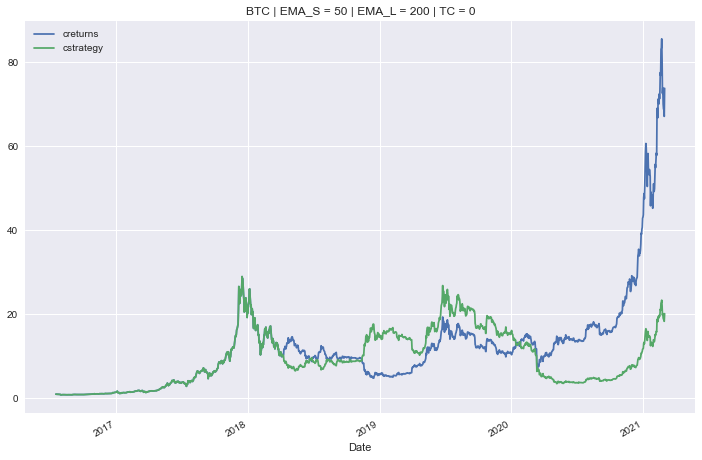

In [80]:
tester_E.plot_results()

In [105]:
tester_E.optimize_parameters((9, 50, 1), (100, 300, 1))

(array([ 21., 102.]), 221.140812)

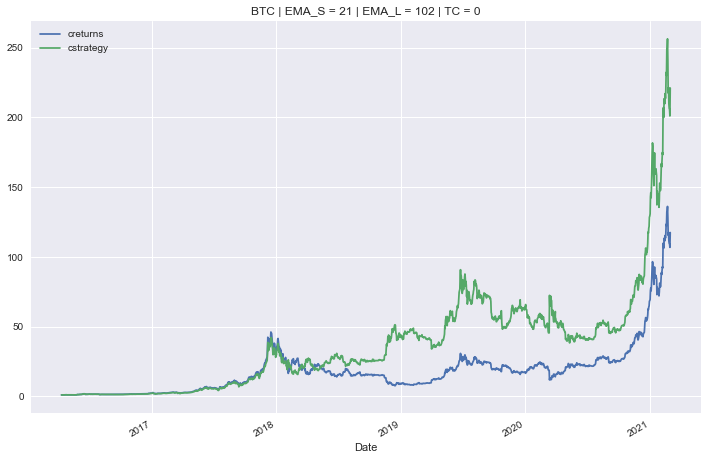

In [106]:
tester_E.plot_results()

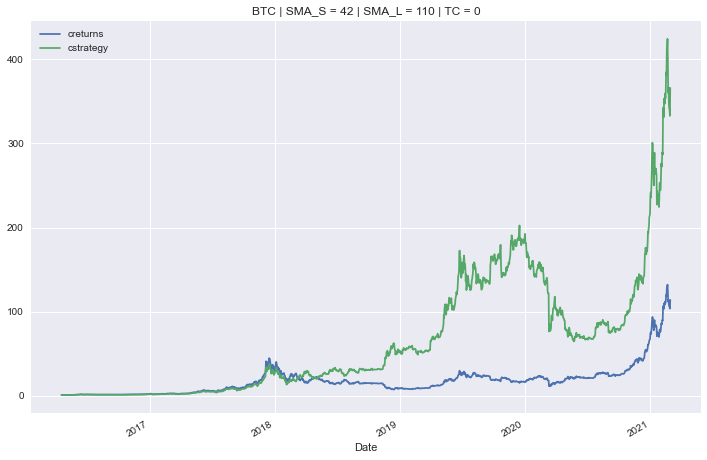

In [107]:
#plotando o otimizado para SMA. Melhor ou pior?
tester_S.plot_results()

### Backtesting & Forward Testing

In [108]:
train_E = EMABacktester("BTC", 50, 200, "2016-01-01", "2019-10-01", 0)

In [109]:
train_E.optimize_parameters((9, 50, 1), (100, 300, 1))

(array([ 47., 109.]), 66.475362)

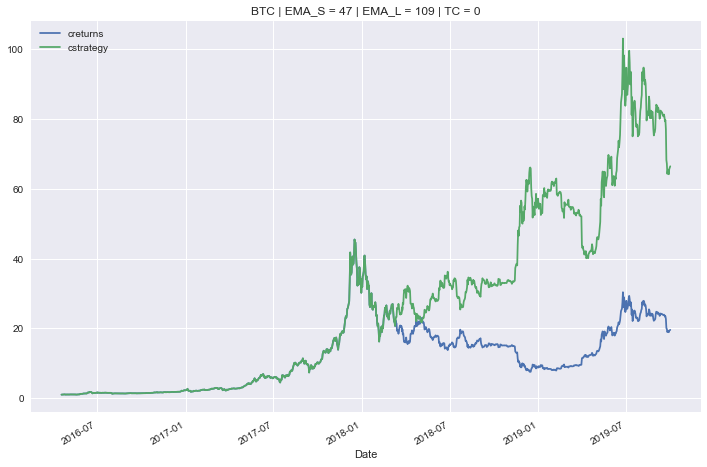

In [110]:
train_E.plot_results()

In [111]:
#AQUI.......... #sma curta e longa tomados dos melhores resultados do treinamento (acima)

tester_O2 = EMABacktester("BTC", 47, 109, "2019-10-01", "2021-03-01", 0)

In [112]:
tester_O2.test_strategy()

(1.599029,
 -3.95082,
 0.0    402
 2.0      2
 Name: trades, dtype: int64)

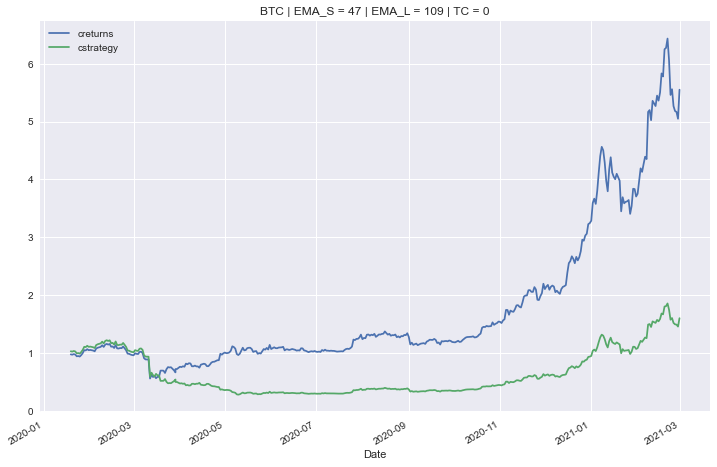

In [114]:
tester_O2.plot_results()
#o resultado da estratégia foi melhor ou pior?

In [115]:
tester_O2.optimize_parameters((9, 50, 1), (100, 300, 1))

(array([  9., 210.]), 5.826374)

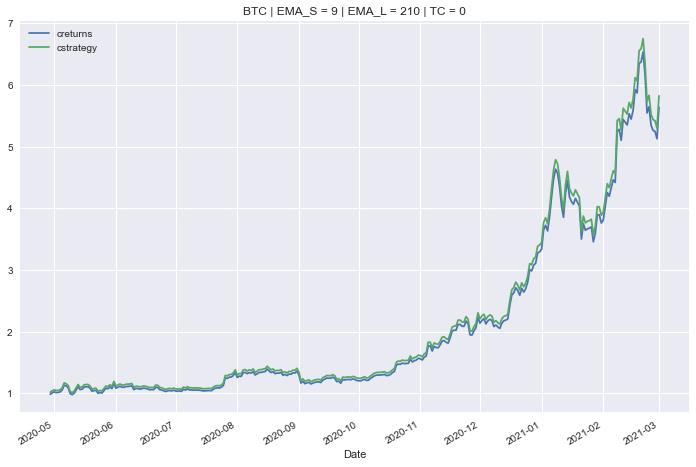

In [119]:
tester_O2.plot_results()

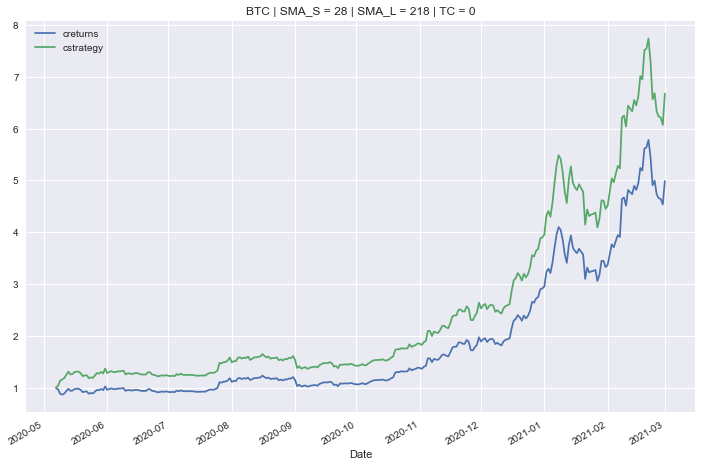

In [120]:
tester_O1.plot_results() #para SMA

In [117]:
#life still not easy

# SMA x EMA Optimizer

In [121]:
class SMAEMABacktester(): 
    ''' Class for the vectorized backtesting of SMA/EMA-based trading strategies.

    Attributes
    ==========
    symbol: str
        ticker symbol with which to work with
    SMA: int
        time window in days for SMA
    EMA: int
        time window in days for EMA
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
    tc: float
        proportional transaction costs per trade
        
        
    Methods
    =======
    get_data:
        retrieves and prepares the data
        
    set_parameters:
        sets one or two new SMA/EMA parameters
        
    test_strategy:
        runs the backtest for the SMA/EMA-based strategy
        
    plot_results:
        plots the performance of the strategy compared to buy and hold
        
    update_and_run:
        updates EMA parameters and returns the negative absolute performance (for minimization algorithm)
        
    optimize_parameters:
        implements a brute force optimization for the two SAM/EMA parameters
    '''
    
    def __init__(self, symbol, SMA, EMA, start, end, tc):
        self.symbol = symbol
        self.SMA = SMA
        self.EMA = EMA
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None 
        self.get_data()
        
    def __repr__(self):
        return "SMAEMABacktester(symbol = {}, SMA = {}, EMA = {}, start = {}, end = {})".format(self.symbol, self.SMA, self.EMA, self.start, self.end)
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv("cryptos.csv", parse_dates = ["Date"], index_col = "Date")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        raw["SMA"] = raw["price"].rolling(self.SMA).mean() 
        raw["EMA"] = raw["price"].ewm(span = self.EMA, min_periods = self.EMA).mean() 
        self.data = raw
        
    def set_parameters(self, SMA = None, EMA = None):
        ''' Updates SMA/EMA parameters and resp. time series.
        '''
        if SMA is not None:
            self.SMA = SMA
            self.data["SMA"] = self.data["price"].rolling(self.SMA).mean() 
        if EMA is not None:
            self.EMA = EMA
            self.data["EMA"] = self.data["price"].ewm(span = self.EMA, min_periods = self.EMA).mean()
            
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data["EMA"] > data["SMA"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine when a trade takes place
        data["trades"] = data.position.diff().fillna(0).abs()
        trades=data.trades.value_counts()
        
        # subtract transaction costs from return when trade takes place
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        perf = data["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
        return round(perf, 6), round(outperf, 6), trades
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = "{} | SMA = {} | EMA = {} | TC = {}".format(self.symbol, self.SMA, self.EMA, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
        
    def update_and_run(self, SMAEMA):
        ''' Updates SMA/EMA parameters and returns the negative absolute performance (for minimization algorithm).

        Parameters
        ==========
        SMAEMA: tuple
            SMA/EMA parameter tuple
        '''
        self.set_parameters(int(SMAEMA[0]), int(SMAEMA[1]))
        return -self.test_strategy()[0]
    
    def optimize_parameters(self, SMA_range, EMA_range):
        ''' Finds global maximum given the SMA/EMA parameter ranges.

        Parameters
        ==========
        SMA_range, EMA_range: tuple
            tuples of the form (start, end, step size)
        '''
        opt = brute(self.update_and_run, (SMA_range, EMA_range), finish=None)
        return opt, -self.update_and_run(opt)

In [122]:
tester_SE = SMAEMABacktester("BTC", 50, 50, "2016-01-01", "2021-03-01", 0)
tester_SE

SMAEMABacktester(symbol = BTC, SMA = 50, EMA = 50, start = 2016-01-01, end = 2021-03-01)

In [123]:
tester_SE.test_strategy()

(13.060415,
 -104.888756,
 0.0    1788
 2.0      45
 Name: trades, dtype: int64)

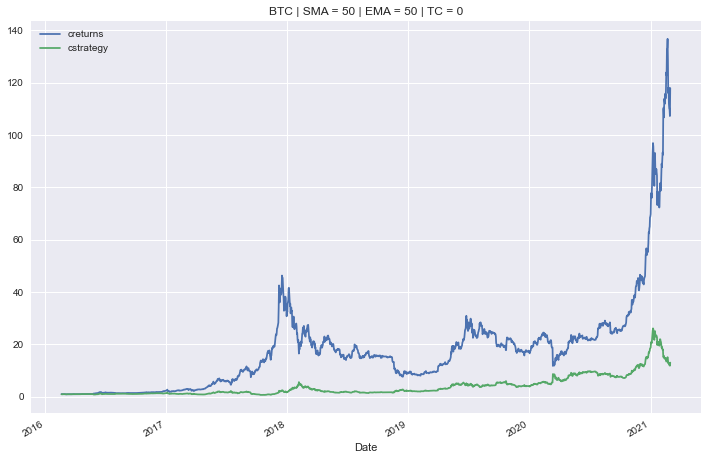

In [124]:
# SMA x EMa 50,50 não funciona
tester_SE.plot_results()

In [125]:
tester_SE.optimize_parameters((9, 300, 1), (9, 300, 1))

(array([23., 20.]), 1865.644319)

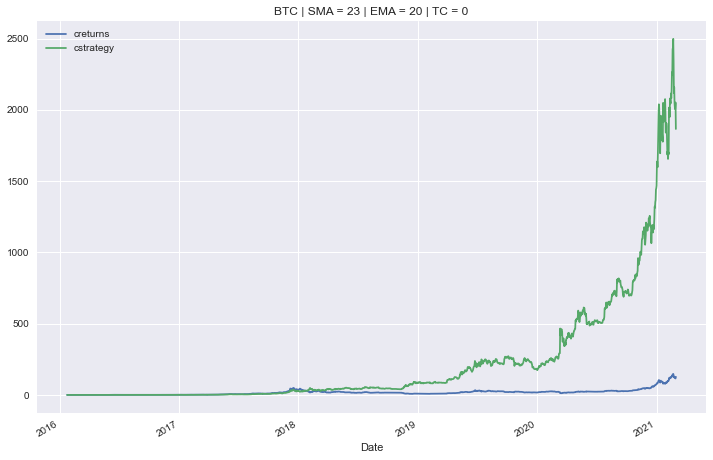

In [126]:
tester_SE.plot_results()

### Backtesting & Forward Testing

In [127]:
train_SE = SMAEMABacktester("BTC", 50, 50, "2016-01-01", "2019-10-01", 0)

In [128]:
train_SE.optimize_parameters((9, 300, 1), (9, 300, 1))

(array([23., 20.]), 259.903915)

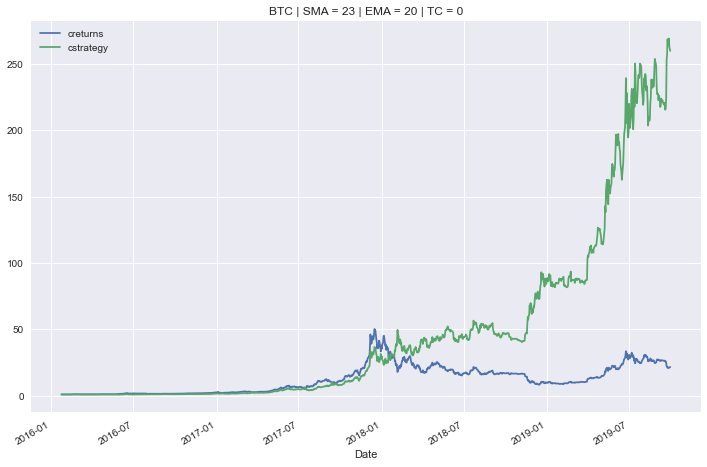

In [129]:
train_SE.plot_results()

In [130]:
#AQUI.......... #sma curta e longa tomados dos melhores resultados do treinamento (acima)

tester_O3 = SMAEMABacktester("BTC", 23, 20, "2019-10-01", "2021-03-01", 0)

In [131]:
tester_O3.test_strategy()

(6.9352,
 0.311951,
 0.0    468
 2.0     22
 Name: trades, dtype: int64)

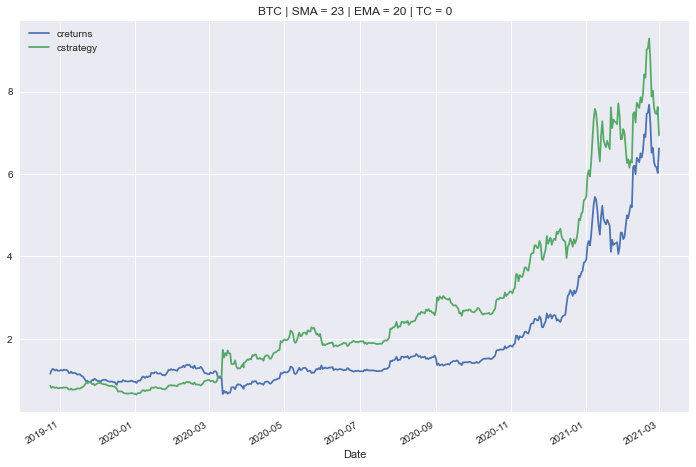

In [132]:
tester_O3.plot_results()
#o resultado da estratégia foi melhor ou pior?

In [115]:
tester_O3.optimize_parameters((9, 300, 1), (9, 300, 1))

(array([  9., 210.]), 5.826374)

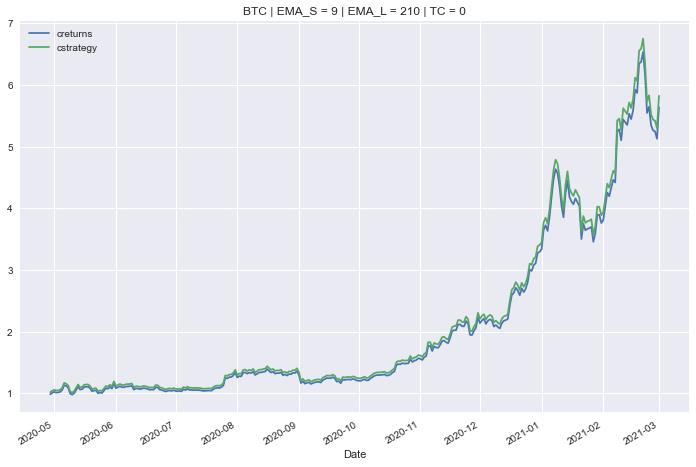

In [119]:
tester_O3.plot_results()